In [2]:
import string
import re
import collections
import csv
import pandas as pd
import numpy as np
import requests
import os
import json
from hyphen import Hyphenator

import dask.dataframe as dd
import multiprocessing

import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

import seaborn as sns

%matplotlib inline

import stanfordnlp
from stanfordnlp.server import CoreNLPClient

import nltk
nltk.download('punkt')

# Uncomment if needed to fix this error:
# OMP: Error #15: Initializing libiomp5md.dll, but found libiomp5md.dll already initialized.
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

NLP_PORT = 9002
WORDS_API_KEY = ''

ModuleNotFoundError: No module named 'hyphen'

In [ ]:
PREDICTION_PATH = './predictions'
TEST_SETS_PATH = './test_sets'

#SET_NAMES = ['Amazon', 'Reddit', 'New-Wiki', 'NYT', 'dev-v1.1']
SET_NAMES = ['Amazon', 'Reddit', 'New-Wiki', 'NYT']

nlp = stanfordnlp.Pipeline(processors='tokenize', use_gpu=True)

In [ ]:
def load_data(input_file_path):
    with open(input_file_path, 'r', encoding='utf-8') as csv_file:
        csv_reader = csv.DictReader(csv_file)
        return [r for r in csv_reader]

In [ ]:
df_answers = pd.read_csv('answers.csv')
df_distinct_answers = pd.read_csv('distinct_answers.csv')
df_distinct_context = pd.read_csv('distinct_context.csv')
df_merged_answers = pd.read_csv('merged_answers.csv')
df_merged_answers_and_context = pd.read_csv('merged_answers_and_context.csv')
df_pred_answers_context = pd.read_csv('pred_answers_context.csv')

df_pred = pd.DataFrame(load_data(PREDICTION_PATH + '/all_predictions.csv'))

In [ ]:
df_pred = df_pred.astype({'f1': 'float'})


In [ ]:
df_pred['f1'].hist(by=df_pred['test_set'],density=True)

In [ ]:
fig, axes = plt.subplots(1,4, figsize= (23,5))
fig.suptitle('Test Set F1 Histogram by %')
for i, test_set in enumerate(['New-Wiki', 'NYT', 'Reddit', 'Amazon']):
    data = df_pred[df_pred['test_set'] == test_set]['f1']
    data.plot.hist(ax=axes.flat[i], 
            bins=20, 
            weights=np.ones(len(data)) / len(data),
            ylim=(0,.8),
            grid = True
           )
    axes.flat[i].set_title(test_set)
for ax in axes:
    ax.yaxis.set_major_formatter(PercentFormatter(1))

In [ ]:
fig, axes = plt.subplots(1,4, figsize= (20,5))
fig.suptitle('Test Set F1 Histogram by Count')
for i, test_set in enumerate(df_pred['test_set'].unique()):
    data = df_pred[df_pred['test_set'] == test_set]['f1']
    data.hist(ax=axes.flat[i], 
            bins=20
           )
    axes.flat[i].set_title(test_set)

In [ ]:
fig, axes = plt.subplots(1,1)
axes.hist(df_pred[df_pred['test_set'] == 'Amazon']['f1'], 
          weights=np.ones(len(df_pred[df_pred['test_set'] == 'Amazon']['f1'])) / len(df_pred[df_pred['test_set'] == 'Amazon']['f1']) )
plt.show()

In [ ]:
df_distinct_context.sort_values(
    'flesch-kincaid_grade_level', 
    ascending=False).iloc[2:3][[
                                'sentence_count', 
                                'word_count', 
                                'flesch-kincaid_grade_level', 
                                'coleman-liau', 
                                'gunning-fog', 
                                'automated-readability']]

In [ ]:
df_merged_answers[:2]

In [ ]:
df_merged_answers[~df_merged_answers['is_numeric']].groupby('const_parse_roots').count()

In [ ]:
df_merged_answers[df_merged_answers['is_numeric']].groupby('const_parse_roots').count()

In [ ]:
### START HERE ###
df_pred_answers_context[df_pred_answers_context['f1']< 1][['test_set_x', 'model_name', 'f1', 'syllables_per_word']]

In [ ]:
df_pred_answers_context[(df_pred_answers_context['test_set'] == 'Amazon') & (df_pred_answers_context['model_name'] == 'xlnet-123(singlemodel)')][['f1','syllables_per_word']].corr().loc[['f1']]

In [ ]:
for metric_name in ['f1', 'exact_match']:

    fig, axes = plt.subplots(1,4, figsize= (22,5))

    metric_list = [metric_name ,'syllables_per_word', 'polysyllable_count','avg_word_length','avg_sentence_length_in_words','context_character_count',
                                              'avg_sentence_length_in_characters','flesch-kincaid_grade_level','coleman-liau','gunning-fog','automated-readability', 'lexical_diversity', 'lexical_diversity_lower']
    #metric_list = ['f1', 'flesch-kincaid_grade_level','coleman-liau','gunning-fog','automated-readability', 'lexical_diversity', 'lexical_diversity_lower']
    for i, model in enumerate(SET_NAMES):
        corrMatrix = df_pred_answers_context[(df_pred_answers_context['test_set'] == model)][metric_list].corr().loc[[metric_name]]
        p = sns.heatmap(corrMatrix, annot=True, ax = axes.flat[i], fmt=".2f")
        axes.flat[i].set_title(model)

        #p.set_xticklabels(p.get_xticklabels(), rotation = 0)

    fig.tight_layout()
    #plt.savefig('test.jpg')   

In [ ]:
#fig, axes = plt.subplots(len(model_list), len(SET_NAMES), figsize=(30, 150))
corr_results = []
#f1_results = []
col_list = ['f1', 'exact_match','syllables_per_word', 'polysyllable_count','avg_word_length','avg_sentence_length_in_words','context_character_count',
                                          'avg_sentence_length_in_characters','flesch-kincaid_grade_level','coleman-liau','gunning-fog','automated-readability', 'lexical_diversity', 'lexical_diversity_lower']
#metric_list = ['exact_match', 'flesch-kincaid_grade_level','coleman-liau','gunning-fog','automated-readability', 'lexical_diversity', 'lexical_diversity_lower']
metric_list = ['f1', 'exact_match']
for metric_name in metric_list:
    for j, model_set in enumerate(SET_NAMES):
        corr_matrix = df_pred_answers_context[(df_pred_answers_context['test_set'] == model_set)][[c for c in col_list if c not in [x for x in metric_list if x != metric_name]]].corr().loc[[metric_name]]
        #f1_matrix = df_pred_answers_context[(df_pred_answers_context['test_set'] == model_set)][[c for c in col_list if c != 'exact_match']].corr().loc[['f1']]

#         p = sns.heatmap(corrMatrix, annot=True, ax = axes[i,j], fmt=".2f")
#         axes[i,j].set_title(model_name + ': ' + model_set)

#        em_matrix['model_name'] = model_name
        corr_matrix['model_set'] = model_set
        corr_matrix['metric_name'] = metric_name

 #       f1_matrix['model_name'] = model_name
 #       f1_matrix['model_set'] = model_set

        corr_results.append(corr_matrix.reset_index(drop=True).drop(columns=[metric_name]).set_index(['model_set', 'metric_name']))
 #       f1_results.append(f1_matrix.reset_index(drop=True).drop(columns=['f1']).set_index(['model_set']))
        
f, ax = plt.subplots(figsize = (10,8)) 
ax = sns.heatmap(pd.concat(corr_results), annot=True, fmt=".2f", linewidths=.2, center=0, vmin=-1, vmax=1)
ax.set_yticklabels(ax.get_yticklabels(), rotation = 0)
ax.set_ylabel('Model Set - Metric')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha='right')
plt.show()        


# fig.tight_layout()
#plt.savefig('test.jpg') 

In [ ]:
sns.heatmap(pd.concat(corr_results))

In [ ]:
metric_list = ['f1', 'exact_match']
metric_name = 'f1'
col_list = ['f1', 'exact_match','syllables_per_word', 'polysyllable_count','avg_word_length','avg_sentence_length_in_words','context_character_count',
                                          'avg_sentence_length_in_characters','flesch-kincaid_grade_level','coleman-liau','gunning-fog','automated-readability', 'lexical_diversity', 'lexical_diversity_lower']
df_pred_answers_context[(df_pred_answers_context['test_set'] == model_set)][[c for c in col_list if c not in [x for x in metric_list if x != metric_name]]].corr().loc[[metric_name]]

In [ ]:
# f, ax = plt.subplots(figsize = (10,8)) 
# ax = sns.heatmap(pd.concat(em_results), annot=True, fmt=".2f", linewidths=.2, center=0, vmin=-1, vmax=1)
# ax.set_yticklabels(ax.get_yticklabels(), rotation = 0)

In [ ]:
em_results = []
f1_results = []
model_list = df_pred_answers_context['display_name'].unique()

#fig, axes = plt.subplots(len(model_list), len(SET_NAMES), figsize=(30, 150))

metric_list = ['f1', 'exact_match','syllables_per_word', 'polysyllable_count','avg_word_length','avg_sentence_length_in_words','context_character_count',
                                          'avg_sentence_length_in_characters','flesch-kincaid_grade_level','coleman-liau','gunning-fog','automated-readability', 'lexical_diversity', 'lexical_diversity_lower']
#metric_list = ['exact_match', 'flesch-kincaid_grade_level','coleman-liau','gunning-fog','automated-readability', 'lexical_diversity', 'lexical_diversity_lower']

for i, model_name in enumerate(model_list):
    for j, model_set in enumerate(SET_NAMES):
        em_matrix = df_pred_answers_context[(df_pred_answers_context['display_name'] == model_name) & (df_pred_answers_context['test_set'] == model_set)][[c for c in metric_list if c != 'f1']].corr().loc[['exact_match']]
        f1_matrix = df_pred_answers_context[(df_pred_answers_context['display_name'] == model_name) & (df_pred_answers_context['test_set'] == model_set)][[c for c in metric_list if c != 'exact_match']].corr().loc[['f1']]
        
#         p = sns.heatmap(corrMatrix, annot=True, ax = axes[i,j], fmt=".2f")
#         axes[i,j].set_title(model_name + ': ' + model_set)
        
        em_matrix['model_name'] = model_name
        em_matrix['model_set'] = model_set
        
        f1_matrix['model_name'] = model_name
        f1_matrix['model_set'] = model_set
        
        em_results.append(em_matrix.reset_index(drop=True).drop(columns=['exact_match']).set_index(['model_name', 'model_set']))
        f1_results.append(f1_matrix.reset_index(drop=True).drop(columns=['f1']).set_index(['model_name', 'model_set']))
        
#         p.set_yticklabels(p.get_yticklabels(), rotation = 0)
    
# fig.tight_layout()
#plt.savefig('test.jpg') 

In [ ]:
corr_em_df = pd.concat(em_results)
#corr_em_df = corr_em_df[['model_name', 'model_set'] + [c for c in corr_em_df.columns if c not in ('model_name','model_set')]]
display(corr_em_df)

corr_f1_df = pd.concat(f1_results)
#corr_f1_df = corr_f1_df[['model_name', 'model_set'] + [c for c in corr_f1_df.columns if c not in ('model_name','model_set')]]
display(corr_f1_df)

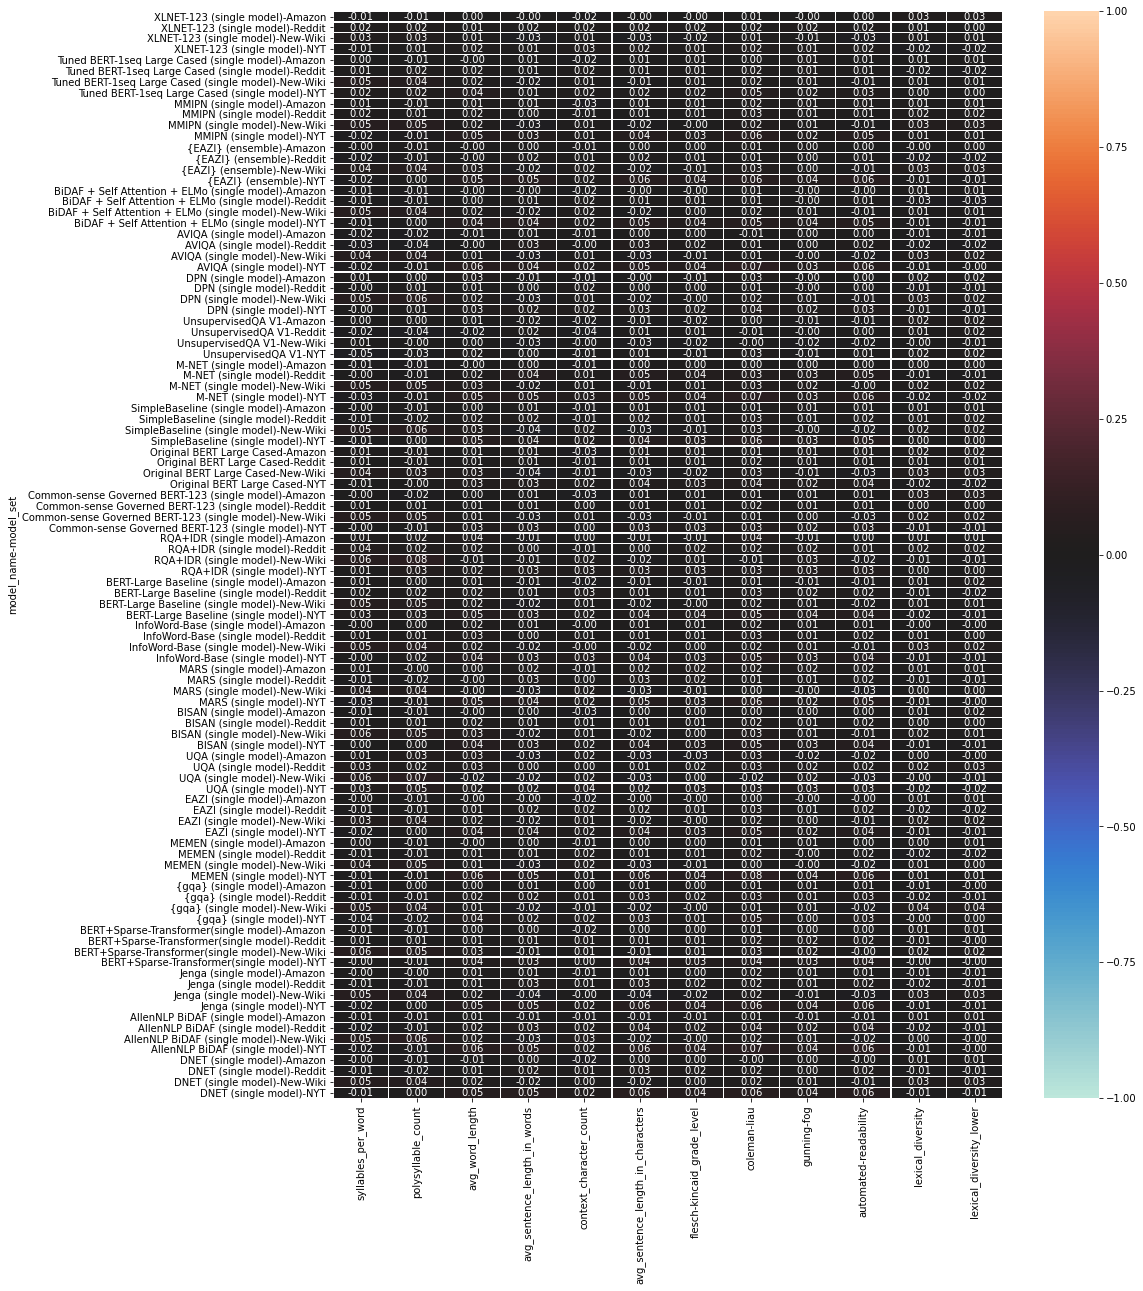

In [165]:
f, ax = plt.subplots(figsize = (15,20))
ax = sns.heatmap(corr_f1_df, annot=True, fmt=".2f", linewidths=.1, center=0, vmin=-1, vmax=1)

In [24]:
pd.DataFrame({'exact_match_max': corr_em_df.max(), 'f1_max': corr_f1_df.max(), 'exact_match_min': corr_em_df.min(), 'f1_min': corr_f1_df.min()})

,exact_match_max,f1_max,exact_match_min,f1_min
syllables_per_word,0.070244,0.058353,-0.040557,-0.045936
polysyllable_count,0.083767,0.076621,-0.036601,-0.040442
avg_word_length,0.057617,0.064188,-0.025360,-0.018041
avg_sentence_length_in_words,0.045521,0.051260,-0.046516,-0.044946
context_character_count,0.032567,0.036664,-0.032314,-0.037361
avg_sentence_length_in_characters,0.051100,0.057590,-0.044279,-0.040027
flesch-kincaid_grade_level,0.039679,0.042953,-0.033771,-0.027005
coleman-liau,0.065279,0.075089,-0.019424,-0.019044
gunning-fog,0.037373,0.038306,-0.030596,-0.021927
automated-readability,0.053711,0.063196,-0.036644,-0.031179


In [177]:
df_distinct_context[df_distinct_context['context'].str.contains('...first off')].loc[[1519]][['sentence_count','word_count','avg_sentence_length_in_words', 'flesch-kincaid_grade_level','coleman-liau','gunning-fog','automated-readability','lexical_diversity']]

,sentence_count,word_count,avg_sentence_length_in_words,flesch-kincaid_grade_level,coleman-liau,gunning-fog,automated-readability,lexical_diversity
1519,1,142,142.0,52.69625,6.807606,58.490141,72.091761,0.725352


In [168]:
em_context_results = []
f1_context_results = []
context_list = df_pred_answers_context['context'].unique()

#fig, axes = plt.subplots(len(model_list), len(SET_NAMES), figsize=(30, 150))

metric_list = ['f1', 'exact_match','syllables_per_word', 'polysyllable_count','avg_word_length','avg_sentence_length_in_words','context_character_count',
                                          'avg_sentence_length_in_characters','flesch-kincaid_grade_level','coleman-liau','gunning-fog','automated-readability', 'lexical_diversity', 'lexical_diversity_lower']
#metric_list = ['exact_match', 'flesch-kincaid_grade_level','coleman-liau','gunning-fog','automated-readability', 'lexical_diversity', 'lexical_diversity_lower']

for i, context in enumerate(context_list):
    
    em_matrix = df_pred_answers_context[(df_pred_answers_context['context'] == context)][[c for c in metric_list if c != 'f1']].corr().loc[['exact_match']]
    f1_matrix = df_pred_answers_context[(df_pred_answers_context['context'] == context)][[c for c in metric_list if c != 'exact_match']].corr().loc[['f1']]

#         p = sns.heatmap(corrMatrix, annot=True, ax = axes[i,j], fmt=".2f")
#         axes[i,j].set_title(model_name + ': ' + model_set)

    em_matrix['context'] = context
    f1_matrix['context'] = context

    em_context_results.append(em_matrix.reset_index(drop=True).drop(columns=['exact_match']).set_index(['context']))
    f1_context_results.append(f1_matrix.reset_index(drop=True).drop(columns=['f1']).set_index(['context']))
        
#         p.set_yticklabels(p.get_yticklabels(), rotation = 0)
    
# fig.tight_layout()
#plt.savefig('test.jpg') 

In [169]:
corr_em_context_df = pd.concat(em_context_results)
#corr_em_df = corr_em_df[['model_name', 'model_set'] + [c for c in corr_em_df.columns if c not in ('model_name','model_set')]]
display(corr_em_context_df)

corr_f1_context_df = pd.concat(f1_context_results)
#corr_f1_df = corr_f1_df[['model_name', 'model_set'] + [c for c in corr_f1_df.columns if c not in ('model_name','model_set')]]
display(corr_f1_context_df)

,syllables_per_word,polysyllable_count,avg_word_length,avg_sentence_length_in_words,context_character_count,avg_sentence_length_in_characters,flesch-kincaid_grade_level,coleman-liau,gunning-fog,automated-readability,lexical_diversity,lexical_diversity_lower
context,,,,,,,,,,,,
"It's a very nice holder - not too big and not too small. It fits any lipstick, lip gloss, chapstick, etc nicely. I love that I'm able to see what I have and not have to dig through a makeup bag anymore. I would highly recommend.",7.699372e-16,NaN,6.272311e-16,NaN,NaN,NaN,-7.699372e-16,-1.073428e-15,4.660285e-16,-3.616675e-16,-8.328488e-16,-8.328488e-16
"First of all, this thing is freakin' awesome. My wife put it together while I did some work, she assembled all the glass shelves in to the frame. We hung it up with 6 BIG 4"" wall toggle bolts. On the top shelf I house an external WD Hdd, a WDTV Live and a Actiontec HDMI WiFi Transmitter. On the second shelf I have my Dish Network 722 (fits perfectly even with all the wires coming out the back). On the bottom shelf I have an old Ken wood Stereo Receive (fits, but the front legs come off just a bit but this doesn't affect stability. The receiver measures 17""w x 14""d x 5""h.The wire maintenance was a little trick. We used a wire coat hanger and some masking tape to thread the bulky wires through the back.This unit installed is an amazing addition to your small living space, I highly recommend it!",4.407139e-16,NaN,2.080748e-17,-4.407139e-16,NaN,1.154829e-16,-3.829750e-16,8.339262e-17,1.477804e-16,6.263813e-17,6.263813e-17,5.607772e-16
"The presto my pod makes, to me, a very weak and watery cup of coffee. It could be just me, I prefer using the medium or dark roast pods, I like strong coffee. I tried using a few different types of coffee in the presto my pod, but it didn't seem to make a difference. I'm not convinced that the pressure is strong enough to brew a decent cup.don't buy this... heck I'll sell you mine for a dollar :-) I'll never use the dang thing again.I followed up by buying the brown eco pod, and THAT worked decently and made a nice cup of coffee by my standards.",-1.635221e-15,NaN,9.424743e-16,NaN,NaN,NaN,NaN,-6.107388e-16,1.664109e-15,5.043700e-16,-6.813419e-16,6.813419e-16
This product takes 10 minutes to setup 4. It is super easy. Very easy on the eyes. It makes the room look like you have a sound system. I used my simple SONY HTIB.The product is stong on the bottom so it's not going to tilt over. The extension part is a bit weak. I have it fully extended as I guess most people would like them. The product because to lose strength and stand a bit off centered. It leans to a side. I wouldn't return them! Just keep in mind that they are a great value and look great. Just has a clumsy feel to it. I tighten them every week when i see them leaning too much.,NaN,NaN,4.899880e-16,-2.822481e-16,NaN,4.899880e-16,5.367985e-16,-1.600024e-16,6.044417e-16,-3.972876e-16,-6.721784e-17,-4.899880e-16
"I have always kept a dustbuster in my kitchen for quick clean ups. They are always charged. Not with this new 18 volt model. Not only does is not have much suction power, you can't keep the battery plugged in so it is always charged and ready to go. If you don't use it for 4-5 days, the charge depletes! So then you have to recharge it for 14-16 hours. Not convenient at all. So I returned the dustbuster. I then ordered a Eureka that works great and can be left plugged in, permanently. The model number is H96. It is not as large as it looks in the photos and is a great buy; not to mention it costs less than the inefficient new dustbusters. The new dustbuster models are now just cheap knock offs of the original great machines. Black and Decker in their attempt to make a higher profit by cheapening a previously great product, destroyed a really good thing.I strongly recommend the Eureka below:Eureka Quick Up Cordless 2 in 1, 96Hproduct.",-2.182579e-16,NaN,-2.114374e-16,3.916951e-16,NaN,2.182579e-16,-8.882437e-

,syllables_per_word,polysyllable_count,avg_word_length,avg_sentence_length_in_words,context_character_count,avg_sentence_length_in_characters,flesch-kincaid_grade_level,coleman-liau,gunning-fog,automated-readability,lexical_diversity,lexical_diversity_lower
context,,,,,,,,,,,,
"It's a very nice holder - not too big and not too small. It fits any lipstick, lip gloss, chapstick, etc nicely. I love that I'm able to see what I have and not have to dig through a makeup bag anymore. I would highly recommend.",-3.370645e-16,NaN,1.463145e-15,NaN,NaN,NaN,3.370645e-16,2.753226e-15,3.267889e-15,-2.519128e-15,2.571171e-15,2.571171e-15
"First of all, this thing is freakin' awesome. My wife put it together while I did some work, she assembled all the glass shelves in to the frame. We hung it up with 6 BIG 4"" wall toggle bolts. On the top shelf I house an external WD Hdd, a WDTV Live and a Actiontec HDMI WiFi Transmitter. On the second shelf I have my Dish Network 722 (fits perfectly even with all the wires coming out the back). On the bottom shelf I have an old Ken wood Stereo Receive (fits, but the front legs come off just a bit but this doesn't affect stability. The receiver measures 17""w x 14""d x 5""h.The wire maintenance was a little trick. We used a wire coat hanger and some masking tape to thread the bulky wires through the back.This unit installed is an amazing addition to your small living space, I highly recommend it!",-3.802590e-15,NaN,-3.872136e-15,3.802590e-15,NaN,3.893291e-15,3.974069e-15,-3.955509e-15,3.975672e-15,3.832634e-15,3.832634e-15,-3.941578e-15
"The presto my pod makes, to me, a very weak and watery cup of coffee. It could be just me, I prefer using the medium or dark roast pods, I like strong coffee. I tried using a few different types of coffee in the presto my pod, but it didn't seem to make a difference. I'm not convinced that the pressure is strong enough to brew a decent cup.don't buy this... heck I'll sell you mine for a dollar :-) I'll never use the dang thing again.I followed up by buying the brown eco pod, and THAT worked decently and made a nice cup of coffee by my standards.",4.635296e-16,NaN,2.028992e-15,NaN,NaN,NaN,NaN,-7.387480e-16,-3.569209e-16,-9.099145e-16,-1.318223e-15,1.318223e-15
This product takes 10 minutes to setup 4. It is super easy. Very easy on the eyes. It makes the room look like you have a sound system. I used my simple SONY HTIB.The product is stong on the bottom so it's not going to tilt over. The extension part is a bit weak. I have it fully extended as I guess most people would like them. The product because to lose strength and stand a bit off centered. It leans to a side. I wouldn't return them! Just keep in mind that they are a great value and look great. Just has a clumsy feel to it. I tighten them every week when i see them leaning too much.,NaN,NaN,-1.933722e-15,1.815580e-15,NaN,-1.933722e-15,1.527717e-15,-1.343363e-15,-1.461394e-15,-1.681199e-15,1.339551e-15,1.933722e-15
"I have always kept a dustbuster in my kitchen for quick clean ups. They are always charged. Not with this new 18 volt model. Not only does is not have much suction power, you can't keep the battery plugged in so it is always charged and ready to go. If you don't use it for 4-5 days, the charge depletes! So then you have to recharge it for 14-16 hours. Not convenient at all. So I returned the dustbuster. I then ordered a Eureka that works great and can be left plugged in, permanently. The model number is H96. It is not as large as it looks in the photos and is a great buy; not to mention it costs less than the inefficient new dustbusters. The new dustbuster models are now just cheap knock offs of the original great machines. Black and Decker in their attempt to make a higher profit by cheapening a previously great product, destroyed a really good thing.I strongly recommend the Eureka below:Eureka Quick Up Cordless 2 in 1, 96Hproduct.",1.580802e-15,NaN,-1.600248e-15,1.741464e-15,NaN,-1.580802e-15,2.883761e-1

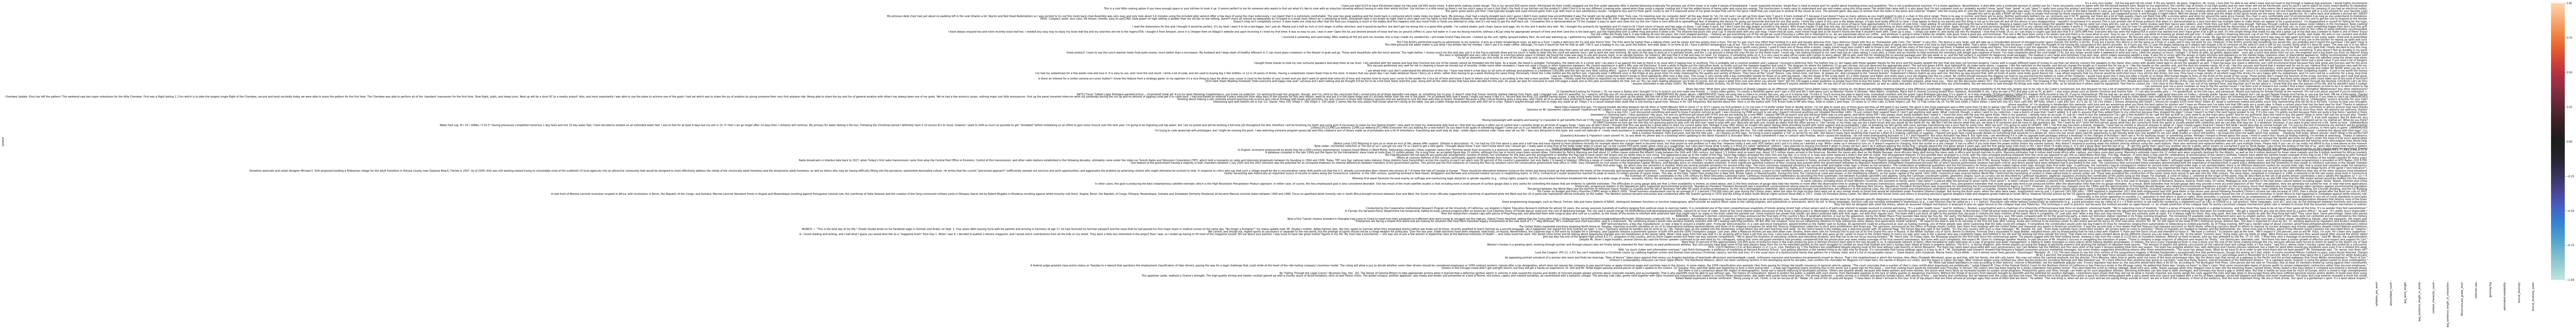

In [170]:
f, ax = plt.subplots(figsize = (15,20))
ax = sns.heatmap(corr_f1_context_df, annot=True, fmt=".2f", linewidths=.1, center=0, vmin=-1, vmax=1)

In [171]:
pd.DataFrame({'exact_match_max': corr_em_context_df.max(), 'f1_max': corr_f1_context_df.max(), 'exact_match_min': corr_em_context_df.min(), 'f1_min': corr_f1_context_df.min()})

,exact_match_max,f1_max,exact_match_min,f1_min
syllables_per_word,5.348116e-15,2.864651e-14,-4.654345e-15,-2.589962e-14
polysyllable_count,NaN,NaN,NaN,NaN
avg_word_length,5.348116e-15,3.262808e-14,-4.152806e-15,-2.488847e-14
avg_sentence_length_in_words,4.455110e-15,2.896112e-14,-3.888188e-15,-2.547829e-14
context_character_count,NaN,NaN,NaN,NaN
avg_sentence_length_in_characters,4.298806e-15,2.450955e-14,-3.991766e-15,-3.122390e-14
flesch-kincaid_grade_level,4.454305e-15,2.604264e-14,-4.327733e-15,-2.864651e-14
coleman-liau,5.338670e-15,2.934757e-14,-6.746852e-15,-2.176579e-14
gunning-fog,4.789180e-15,2.729555e-14,-4.430004e-15,-2.630986e-14
automated-readability,4.390486e-15,2.661726e-14,-4.454305e-15,-2.750857e-14


In [59]:
corr_em_df[corr_em_df['polysyllable_count'] == 0.083767]

,,syllables_per_word,polysyllable_count,avg_word_length,avg_sentence_length_in_words,context_character_count,avg_sentence_length_in_characters,flesch-kincaid_grade_level,coleman-liau,gunning-fog,automated-readability,lexical_diversity,lexical_diversity_lower
model_name,model_set,,,,,,,,,,,,


In [25]:
type(corr_f1_df.max())

pandas.core.series.Series

In [26]:
pd.set_option('display.max_rows', 20)
df_pred_answers_context[df_pred_answers_context['context'] == df_distinct_context.sort_values('flesch-kincaid_grade_level', ascending=False).iloc[2]['context']][['question_text', 'answer_text', 'predicted_answer', 'f1', 'exact_match']].drop_duplicates()

,question_text,answer_text,predicted_answer,f1,exact_match


In [27]:
df_distinct_answers['answer_text'][0]

'not too big and not too small'

In [28]:
#import tensorflow as tf
import tensorflow.compat.v1 as tf
import tensorflow_hub as hub
#import tensorflow as tf

In [29]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [30]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

In [31]:
from absl import logging

import tensorflow as tf

import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" 
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  return model(input)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [32]:
df_pred[df_pred['test_set'] == 'Amazon'][['model_name','f1', 'qid', 'predicted_answer']].sort_values(['model_name', 'qid'])

,model_name,f1,qid,predicted_answer
866892,allennlpbidaf(singlemodel),0.823529,5dd465dacc027a086d65bc6c,very nice holder - not too big and not too small
866893,allennlpbidaf(singlemodel),0.888889,5dd465dacc027a086d65bc6d,"any lipstick, lip gloss"
866894,allennlpbidaf(singlemodel),1.000000,5dd465dacc027a086d65bc6e,I would highly recommend
866895,allennlpbidaf(singlemodel),0.000000,5dd465dacc027a086d65bc6f,I love
866896,allennlpbidaf(singlemodel),0.000000,5dd465dacc027a086d65bc70,"any lipstick, lip gloss, chapstick"
...,...,...,...,...
763699,{gqa}(singlemodel),0.727273,5dd67811cc027a086d665454,someone who has heavy duty cleaning needs
763700,{gqa}(singlemodel),1.000000,5dd67811cc027a086d665455,corporate cleaning
763701,{gqa}(singlemodel),0.000000,5dd67811cc027a086d665456,HEPA filter bags
763703,{gqa}(singlemodel),1.000000,5dd67811cc027a086d665457,HEPA


In [33]:
import tensorflow_datasets as tfds

In [34]:
squad_ds = tfds.load('squad')

In [35]:
x = squad_ds['train'].take(1)

In [36]:
for a in x:
    #print(a['context'])
    print(tf.unique_with_counts(tf.strings.split(a['context'])))
    print('\n')
    print(tf.unique_with_counts(tf.strings.split(tf.strings.lower(a['context']))))

UniqueWithCounts(y=<tf.Tensor: shape=(70,), dtype=string, numpy=
array([b'The', b'difference', b'in', b'the', b'above', b'factors', b'for',
       b'case', b'of', b'\xce\xb8=0', b'is', b'reason', b'that', b'most',
       b'broadcasting', b'(transmissions', b'intended', b'public)',
       b'uses', b'vertical', b'polarization.', b'For', b'receivers',
       b'near', b'ground,', b'horizontally', b'polarized',
       b'transmissions', b'suffer', b'cancellation.', b'best',
       b'reception', b'receiving', b'antennas', b'these', b'signals',
       b'are', b'likewise', b'vertically', b'polarized.', b'In', b'some',
       b'applications', b'where', b'antenna', b'must', b'work', b'any',
       b'position,', b'as', b'mobile', b'phones,', b'base', b'station',
       b'use', b'mixed', b'polarization,', b'such', b'linear',
       b'polarization', b'at', b'an', b'angle', b'(with', b'both', b'and',
       b'horizontal', b'components)', b'or', b'circular'], dtype=object)>, idx=<tf.Tensor: shape=(87,

In [37]:
s = "All the Whos down in Whoville liked Christmas a lot. But the Grinch, who lived just north of Whoville, did not."
print(tf.unique_with_counts(tf.keras.preprocessing.text.text_to_word_sequence(s)))

UniqueWithCounts(y=<tf.Tensor: shape=(19,), dtype=string, numpy=
array([b'all', b'the', b'whos', b'down', b'in', b'whoville', b'liked',
       b'christmas', b'a', b'lot', b'but', b'grinch', b'who', b'lived',
       b'just', b'north', b'of', b'did', b'not'], dtype=object)>, idx=<tf.Tensor: shape=(21,), dtype=int32, numpy=
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,  1, 11, 12, 13, 14, 15,
       16,  5, 17, 18])>, count=<tf.Tensor: shape=(19,), dtype=int32, numpy=array([1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])>)


In [38]:
len(s.split())

21

In [39]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [40]:
t = tf.keras.preprocessing.text.Tokenizer()

In [41]:
tf.keras.preprocessing.text.text_to_word_sequence(s)

['all',
 'the',
 'whos',
 'down',
 'in',
 'whoville',
 'liked',
 'christmas',
 'a',
 'lot',
 'but',
 'the',
 'grinch',
 'who',
 'lived',
 'just',
 'north',
 'of',
 'whoville',
 'did',
 'not']

In [42]:
s1 = "All the Whos down in Whoville liked Christmas a lot."
s2 = "But the Grinch, who lived just north of Whoville, did not."

t_s1 = tf.unique_with_counts(tf.keras.preprocessing.text.text_to_word_sequence(s1))
t_s2 = tf.unique_with_counts(tf.keras.preprocessing.text.text_to_word_sequence(s2))

In [43]:
t.fit_on_texts([s1, s2])

In [44]:
t.document_count

2

In [45]:
t.fit_on_texts(squad_ds['train']['context'])

TypeError: 'PrefetchDataset' object is not subscriptable

In [46]:
squad_text = [x['context'].decode() for x in list(tfds.as_numpy(squad_ds['train']))]

In [47]:
len(squad_text)

87599

In [48]:
squad_text[0]

'The difference in the above factors for the case of θ=0 is the reason that most broadcasting (transmissions intended for the public) uses vertical polarization. For receivers near the ground, horizontally polarized transmissions suffer cancellation. For best reception the receiving antennas for these signals are likewise vertically polarized. In some applications where the receiving antenna must work in any position, as in mobile phones, the base station antennas use mixed polarization, such as linear polarization at an angle (with both vertical and horizontal components) or circular polarization.'

In [49]:
all_squad_words = tf.keras.preprocessing.text.text_to_word_sequence(' '.join(squad_text))
words_with_counts = tf.unique_with_counts(all_squad_words)

## Test Set Aggregate Analysis

In [50]:
# Get the SQuAD training set data for later comparisons

with open(TEST_SETS_PATH + '/train-v2.0.json') as f:
    s_json = json.load(f)
    
full_squad_text = ' '.join([x['context'] for y in s_json['data'] for x in y['paragraphs']])    

squad_freqdist = nltk.FreqDist(nltk.tokenize.word_tokenize(full_squad_text))
squad_freqdist_lower = nltk.FreqDist(nltk.tokenize.word_tokenize(full_squad_text.lower()))

# SQuAD lexical diversity
print('SQuAD Training Lexical Diversity:', len(set(nltk.tokenize.word_tokenize(full_squad_text)))/len(nltk.tokenize.word_tokenize(full_squad_text)))
print('SQuAD Training Lexical Diversity (lower case):', len(set(nltk.tokenize.word_tokenize(full_squad_text.lower())))/len(nltk.tokenize.word_tokenize(full_squad_text.lower())))

SQuAD Training Lexical Diversity: 0.043178504959439146
SQuAD Training Lexical Diversity (lower case): 0.03877918893738047


In [51]:
test_text = s_json['data'][0]['paragraphs'][0]['context']

In [52]:
len(nltk.FreqDist(nltk.tokenize.word_tokenize(test_text)))

95

In [53]:
len(nltk.FreqDist(tf.keras.preprocessing.text.text_to_word_sequence(test_text)))

88

In [54]:
len(nltk.FreqDist([w.text for s in nlp(test_text).sentences for w in s.words]))
#         sentence_count = len(doc.sentences)
#         words = [w.text for s in doc.sentences for w in s.words if w.text not in string.punctuation]

96

In [55]:
words_with_counts = tf.unique_with_counts(all_squad_words)

In [56]:
df_test_sets = df_distinct_context.groupby(['test_set'], as_index=False).agg({'context': ' '.join})

In [57]:
df_test_sets['freqdist'] = df_test_sets.apply(lambda row: nltk.FreqDist(nltk.tokenize.word_tokenize(row['context'])), axis = 1)
df_test_sets['freqdist_lower'] = df_test_sets.apply(lambda row: nltk.FreqDist(nltk.tokenize.word_tokenize(row['context'].lower())), axis = 1)

df_test_sets['lexical_diversity'] = df_test_sets.apply(lambda row: len(set(nltk.tokenize.word_tokenize(row['context'])))/len(nltk.tokenize.word_tokenize(row['context'])), axis = 1)
df_test_sets['lexical_diversity_lower'] = df_test_sets.apply(lambda row: len(set(nltk.tokenize.word_tokenize(row['context'].lower())))/len(nltk.tokenize.word_tokenize(row['context'].lower())), axis = 1)

df_test_sets['training_overlap'] = df_test_sets.apply(lambda row: len(set.intersection( set(row['freqdist'].keys()), set(squad_freqdist.keys()) ))/len(set(row['freqdist'].keys())), axis = 1)
df_test_sets['training_overlap_lower'] = df_test_sets.apply(lambda row: len(set.intersection( set(row['freqdist_lower'].keys()), set(squad_freqdist_lower.keys() )))/len(set(row['freqdist_lower'].keys())), axis = 1)

df_test_sets['vocab_size'] = df_test_sets.apply(lambda row: len(row['freqdist']), axis = 1)
df_test_sets['vocab_size_lower'] = df_test_sets.apply(lambda row: len(row['freqdist_lower']), axis = 1)

df_test_sets['distinct_in_test'] = df_test_sets.apply(lambda row: set(row['freqdist'].keys()).difference(set(squad_freqdist.keys())), axis = 1)
df_test_sets['distinct_in_test_lower'] = df_test_sets.apply(lambda row: set(row['freqdist_lower'].keys()).difference(set(squad_freqdist_lower.keys())), axis = 1)

df_test_sets['distinct_in_test_size'] = df_test_sets.apply(lambda row: len(row['distinct_in_test']), axis = 1)
df_test_sets['distinct_in_test_size_lower'] = df_test_sets.apply(lambda row: len(row['distinct_in_test_lower']), axis = 1)

df_test_sets['pct_distinct'] = df_test_sets.apply(lambda row: row['distinct_in_test_size']/row['vocab_size'] , axis = 1)
df_test_sets['pct_distinct_lower'] = df_test_sets.apply(lambda row: row['distinct_in_test_size_lower']/row['vocab_size_lower'], axis = 1)

display(df_test_sets)

,test_set,context,freqdist,freqdist_lower,lexical_diversity,lexical_diversity_lower,training_overlap,training_overlap_lower,vocab_size,vocab_size_lower,distinct_in_test,distinct_in_test_lower,distinct_in_test_size,distinct_in_test_size_lower,pct_distinct,pct_distinct_lower
0,amazon_reviews_v1,It's a very nice holder - not too big and not ...,"{'It': 1542, ''s': 1705, 'a': 7881, 'very': 10...","{'it': 8958, ''s': 1710, 'a': 8004, 'very': 11...",0.053352,0.046871,0.536336,0.559995,18095,15893,"{Thankfully, 26-1/3-Ounce, 2013Breadmaker, Coo...","{day.it, book.it, helpful.i, insides, refill, ...",8390,6993,0.463664,0.440005
1,new_wiki_v1,The Monastic Brotherhood consists of the celib...,"{'The': 1835, 'Monastic': 1, 'Brotherhood': 1,...","{'the': 14656, 'monastic': 3, 'brotherhood': 8...",0.106764,0.096543,0.759728,0.765247,23361,21086,"{-water, Guyanese, insides, WBAI, ComCruDesPac...","{-water, brearley, roulston, insides, tit, kas...",5613,4950,0.240272,0.234753
2,nyt_v1,Mattingly’s election to baseball’s Hall of Fam...,"{'Mattingly': 8, '’': 4322, 's': 2837, 'electi...","{'mattingly': 8, '’': 4322, 's': 2841, 'electi...",0.096685,0.087374,0.682765,0.694413,29672,26778,"{little-noticed, Wedged, 53-yard, Titans, Nast...","{little-noticed, 53-yard, bailiff., tic., shak...",9413,8183,0.317235,0.305587
3,reddit_v1,Help with aftermarket mirrors for my boyfriend...,"{'Help': 99, 'with': 2100, 'aftermarket': 5, '...","{'help': 599, 'with': 2153, 'aftermarket': 5, ...",0.082685,0.069081,0.568413,0.601520,27575,23020,"{Brazzers, Thankfully, MUSIC, hairdryer, Webca...","{skype-irc-reddit, hairdryer, hh, glob, riden,...",11901,9173,0.431587,0.398480
4,train-v2,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,"{'Beyoncé': 216, 'Giselle': 2, 'Knowles-Carter...","{'beyoncé': 216, 'giselle': 2, 'knowles-carter...",0.043270,0.038875,1.000000,1.000000,109642,98323,{},{},0,0,0.000000,0.000000


In [78]:
df_pred_answers_context[['test_set', 'model_name', 'description', 'qid', 'context', 'question_text', 'answer_text', 'exact_match', 'f1']] \
    .groupby(['test_set', 'model_name', 'description', 'qid', 'context', 'question_text', 'exact_match', 'f1'], as_index=False).apply(lambda row: list(set(row['answer_text'])))

test_set  model_name                  description                    qid                       context                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    question_text                                       exact_match  f1      
Amazon    allennlpbidaf(singlemodel)  AllenNLP BiDAF (single model)  5dd465dacc027a086d65bc6c  It's a very nice holder - not too big and not too small. It fits any lipstick, lip gloss, chapstick, etc nicely. I love that I'm able to see what I have and not have to dig through a makeup bag any

In [132]:
df_best = df_pred_answers_context[['context', 'exact_match', 'f1']] \
    .groupby(['context'], as_index=False).agg({'exact_match': 'mean', 'f1': 'mean'}) \
    .sort_values('f1')[-5:].reset_index(drop=True)

df_worst = df_pred_answers_context[['context', 'exact_match', 'f1']] \
    .groupby(['context'], as_index=False).agg({'exact_match': 'mean', 'f1': 'mean'}) \
    .sort_values('f1')[:5].reset_index(drop=True)

df_best_worst = pd.concat([df_best, df_worst]).reset_index(drop=True)


In [133]:
df_best_worst

,context,exact_match,f1
0,Mark Nordenberg was chancellor of the Universi...,0.992000,0.998000
1,The department also created a capital projects...,1.000000,1.000000
2,"The building, which originally had 17 rentals ...",1.000000,1.000000
3,Perhaps this is Mr. Simon refusing to invent m...,1.000000,1.000000
4,This border-straddling ISIS sanctuary must be ...,1.000000,1.000000
5,Building a team for raiding (how do you format...,0.042857,0.128933
6,It fills many needs. As stated in the descript...,0.070000,0.136185
7,Help Fix my Screw-up Please. In addition to lu...,0.128000,0.174736
8,Q. How does Puerto Rico compare to Greece? A....,0.173333,0.176000
9,Overlays. Tactical Overlay: 1: Go to LINKREMOV...,0.108571,0.179457


In [134]:
df_best_worst_merge = df_pred_answers_context[['test_set', 'model_name', 'description', 'qid', 'context', 'question_text', 'predicted_answer', 'answer_text', 'exact_match', 'f1']] \
    .merge(df_best_worst, left_on='context', right_on='context') \
    .groupby(['test_set', 'model_name', 'description', 'qid', 'context', 'question_text', 'predicted_answer', 'exact_match_x','f1_x','exact_match_y','f1_y'], as_index=False) \
    .apply(lambda row: list(set(row['answer_text'])))

In [105]:
pd.reset_option('all')


: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.



C:\Users\Justin\Anaconda3\envs\w210_capstone\lib\site-packages\pandas\_config\config.py:620: FutureWarning: 
: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.

  warnings.warn(d.msg, FutureWarning)


In [135]:
type(df_best_worst_merge)

pandas.core.series.Series

In [139]:
df_pred_answers_context[['test_set', 'model_name', 'description', 'qid', 'context', 'question_text', 'predicted_answer', 'answer_text', 'exact_match', 'f1']] \
    .merge(df_best_worst, left_on='context', right_on='context') \
    .groupby(['test_set', 'model_name', 'description', 'qid', 'context', 'question_text', 'predicted_answer', 'exact_match_x','f1_x','exact_match_y','f1_y']) \
    .agg({'answer_text': lambda x: list(set(x))}) \
    .reset_index() \
    .to_csv('best_worst.csv', index=False)

In [146]:
df_pred_answers_context[df_pred_answers_context['qid'].isin(['5d701c0dc8e4820a9b66c78f','5d701c0dc8e4820a9b66c790','5d701c0dc8e4820a9b66c791'])].sort_values('f1')[['predicted_answer', 'answer_text', 'f1']]

,predicted_answer,answer_text,f1
2284506,How,pristine beaches and balmy weather,0.0
2284536,less,pristine beaches and balmy weather,0.0
2284537,less,balmy weather,0.0
2284538,less in common when it comes to how their fisc...,pristine beaches and balmy weather,0.0
2284539,less in common when it comes to how their fisc...,pristine beaches and balmy weather,0.0
...,...,...,...
2284473,pristine beaches and balmy weather,pristine beaches and balmy weather,1.0
2284474,pristine beaches and balmy weather,balmy weather,1.0
2284519,pristine beaches and balmy weather,balmy weather,1.0
2284517,pristine beaches and balmy weather,pristine beaches and balmy weather,1.0


In [151]:
d = df_pred_answers_context[df_pred_answers_context['qid'].isin(['5d701c0dc8e4820a9b66c78f','5d701c0dc8e4820a9b66c790','5d701c0dc8e4820a9b66c791'])][['f1']]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000224107B88B0>]],
      dtype=object)

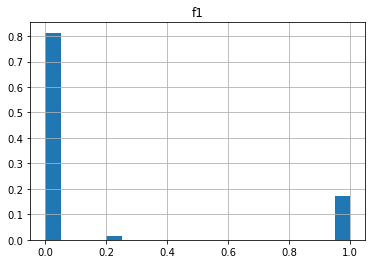

In [152]:
d.hist( 
            bins=20, 
            weights=np.ones(len(d)) / len(d) 
           )

In [122]:
df_answers[df_answers['question_id'] == '5d9ba4938ae5305bc982cbc1']

,test_set,question_id,title,context,question_text,answer_text,answer_start,is_numeric
92273,reddit_v1,5d9ba4938ae5305bc982cbc1,Filtered_Reddit_Comments,Building a team for raiding (how do you format...,a type of format for building a team?,alert,66,False
92274,reddit_v1,5d9ba4938ae5305bc982cbc1,Filtered_Reddit_Comments,Building a team for raiding (how do you format...,a type of format for building a team?,tough,73,False
